In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import WeightedRandomSampler, DataLoader
from tqdm import tqdm
from PIL import Image

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


In [3]:
random_seed= 42

In [4]:
#Creating custom dataset
data_path_train = "C:/Users/M/Desktop/Python/Amber/Data/Train"
data_path_test = "C:/Users/M/Desktop/Python/Amber/Data/Test"
IMG_SIZE = 224

transform = transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize((0.5), (0.5)),
        ]
    )

class CustomDataSet():
       
    def __init__(self,data_path,transform=None):
        
        self.transform = transform
        
        self.data_path = data_path
        self.data = dset.ImageFolder(self.data_path)
        self.nrofclass = len(self.data.classes)
                
        self.custom_data = []
        
        for i in tqdm(range(len(self.data))):
            ImgPath = self.data.samples[i][0]
            img = cv2.imread(ImgPath)
            img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) # gray scale for shape ?
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            Category = self.data.samples[i][1]
            y_label = torch.tensor(np.eye(self.nrofclass)[Category])  # one hot encoding
            #y_label = torch.tensor(Category)
            self.custom_data.append([img, y_label])
           # img.close()
          
    def __len__(self):
        return len(self.custom_data)
    
    def __getitem__(self, idx):
        img, class_id = self.custom_data[idx]
        if self.transform is not None:
            img = self.transform(img)
        return (img, class_id)

DataSetTrain = CustomDataSet(data_path_train,transform=transform)
DataSetTest = CustomDataSet(data_path_test,transform=transform)

100%|█████████████████████████████████████████████████████████████████████████████| 1102/1102 [00:02<00:00, 371.19it/s]


In [6]:
valid_size = int(0.2 * len(DataSetTest))
test_size = len(DataSetTest) - valid_size
valid_dataset, test_dataset = torch.utils.data.random_split(DataSetTest, [valid_size, test_size])

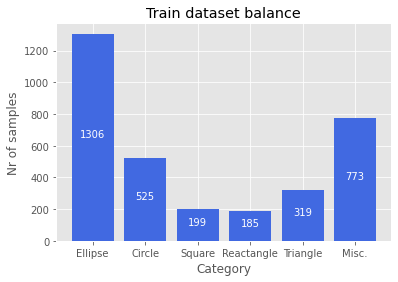

In [8]:
# Checking for class balance
DataSummary = []
for i in range(len(DataSetTrain.data.classes)):
    count = DataSetTrain.data.targets.count(i)
    DataSummary.append(count)

Classes = ('Ellipse', 'Circle', 'Square', 'Reactangle', 'Triangle','Misc.')
DataBalance = dict(zip(Classes,DataSummary))

Categories = list(DataBalance.keys())
Samples = list(DataBalance.values())

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]//2, y[i], ha = 'center', color = 'white')

plt.style.use('ggplot')
plt.title('Train dataset balance')
plt.xlabel('Category')
plt.ylabel('Nr of samples')
plt.bar(Categories,Samples, color = 'royalblue')
addlabels(Categories,Samples)
plt.show()

In [9]:
# Initialise class weights

class_weights = []
for i in range(len(DataSetTrain.data.classes)):
    count = DataSetTrain.data.targets.count(i)
    class_weights.append(1/(count))

sample_weights = [0] * len(DataSetTrain)

for idx, (data, label) in enumerate(DataSetTrain.data):
        class_weight = class_weights[label]
        sample_weights[idx] = class_weight

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

In [10]:
#Data loaders
BATCH_SIZE = 50
train_data_loader = DataLoader(DataSetTrain, 
                               batch_size=BATCH_SIZE,  
                               #shuffle=True
                               sampler=sampler
                               )

test_data_loader = DataLoader(test_dataset, 
                              batch_size=20,  
                             # num_workers=0,
                              shuffle=False
                              )

valid_data_loader = DataLoader(valid_dataset, 
                              batch_size=20,  
                             # num_workers=0,
                              shuffle=True
                              )


In [ ]:
len(DataSetTest)

In [11]:
from torch import Tensor
from typing import Callable, Any, List, Optional

def channel_shuffle(x: Tensor, groups: int) -> Tensor:
    batchsize, num_channels, height, width = x.size()
    channels_per_group = num_channels // groups

    # reshape
    x = x.view(batchsize, groups, channels_per_group, height, width)

    x = torch.transpose(x, 1, 2).contiguous()

    # flatten
    x = x.view(batchsize, -1, height, width)

    return x

class InvertedResidual(nn.Module):
    def __init__(self, inp: int, oup: int, stride: int) -> None:
        super().__init__()

        if not (1 <= stride <= 3):
            raise ValueError("illegal stride value")
        self.stride = stride

        branch_features = oup // 2
        if (self.stride == 1) and (inp != branch_features << 1):
            raise ValueError(
                f"Invalid combination of stride {stride}, inp {inp} and oup {oup} values. If stride == 1 then inp should be equal to oup // 2 << 1."
            )

        if self.stride > 1:
            self.branch1 = nn.Sequential(
                self.depthwise_conv(inp, inp, kernel_size=3, stride=self.stride, padding=1),
                nn.BatchNorm2d(inp),
                nn.Conv2d(inp, branch_features, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(branch_features),
                nn.ReLU(inplace=True),
            )
        else:
            self.branch1 = nn.Sequential()

        self.branch2 = nn.Sequential(
            nn.Conv2d(
                inp if (self.stride > 1) else branch_features,
                branch_features,
                kernel_size=1,
                stride=1,
                padding=0,
                bias=False,
            ),
            nn.BatchNorm2d(branch_features),
            nn.ReLU(inplace=True),
            self.depthwise_conv(branch_features, branch_features, kernel_size=3, stride=self.stride, padding=1),
            nn.BatchNorm2d(branch_features),
            nn.Conv2d(branch_features, branch_features, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(branch_features),
            nn.ReLU(inplace=True),
        )

    @staticmethod
    def depthwise_conv(
        i: int, o: int, kernel_size: int, stride: int = 1, padding: int = 0, bias: bool = False
    ) -> nn.Conv2d:
        return nn.Conv2d(i, o, kernel_size, stride, padding, bias=bias, groups=i)

    def forward(self, x: Tensor) -> Tensor:
        if self.stride == 1:
            x1, x2 = x.chunk(2, dim=1)
            out = torch.cat((x1, self.branch2(x2)), dim=1)
        else:
            out = torch.cat((self.branch1(x), self.branch2(x)), dim=1)

        out = channel_shuffle(out, 2)

        return out


class ShuffleNetV2(nn.Module):
    def __init__(
        self,
        stages_repeats: List[int],
        stages_out_channels: List[int],
        num_classes: int = 6,
        inverted_residual: Callable[..., nn.Module] = InvertedResidual,
    ) -> None:
        super().__init__()
        #_log_api_usage_once(self)

        if len(stages_repeats) != 3:
            raise ValueError("expected stages_repeats as list of 3 positive ints")
        if len(stages_out_channels) != 5:
            raise ValueError("expected stages_out_channels as list of 5 positive ints")
        self._stage_out_channels = stages_out_channels

        input_channels = 1
        output_channels = self._stage_out_channels[0]
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, 3, 2, 1, bias=False),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True),
        )
        input_channels = output_channels

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.stage2: nn.Sequential
        self.stage3: nn.Sequential
        self.stage4: nn.Sequential
        stage_names = [f"stage{i}" for i in [2, 3, 4]]
        for name, repeats, output_channels in zip(stage_names, stages_repeats, self._stage_out_channels[1:]):
            seq = [inverted_residual(input_channels, output_channels, 2)]
            for i in range(repeats - 1):
                seq.append(inverted_residual(output_channels, output_channels, 1))
            setattr(self, name, nn.Sequential(*seq))
            input_channels = output_channels

        output_channels = self._stage_out_channels[-1]
        self.conv5 = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, 1, 1, 0, bias=False),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True),
        )

        self.fc = nn.Linear(output_channels, num_classes)

    def _forward_impl(self, x: Tensor) -> Tensor:
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.conv5(x)
        x = x.mean([2, 3])  # globalpool
        return self.fc(x)   

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

In [12]:
net = ShuffleNetV2([4, 8, 4], [24, 48, 96, 192, 1024])
#net = ShuffleNetV2([4, 8, 4], [24, 244, 488, 976, 2048])
net.to(device)

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(1, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_

In [14]:
EPOCHS = 50
optimizer = optim.Adam(net.parameters(), lr=1e-3)
loss_function = nn.BCEWithLogitsLoss()
steps = len(train_data_loader)
stepsv = len(test_data_loader)
#val_losses = []
#train_losses = []
#val_accs = []
#train_accs = []
for epoch in range(EPOCHS):
    total = 0
    train_acc = 0
    train_loss = 0
    net.train()
    for step in tqdm(range(steps)):
        x, y = next(iter(train_data_loader))
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        outputs = net(x)
        loss = loss_function(outputs, y)
        loss.backward()
        optimizer.step() 
        
        total += y.size(0)
        
        _, predicted = outputs.max(1)
  
        train_acc += (predicted == y.max(1).indices).sum().cpu().detach().numpy()
        train_loss += loss.item()
        
    acct=100.*train_acc/total
    train_accs.append(acct)
    losst= train_loss/len(train_data_loader)
    train_losses.append(losst)
    
    totalv = 0
    val_acc = 0
    val_loss = 0
    net.eval()
    with torch.no_grad():
        for step in tqdm(range(stepsv)):
            vinputs, vlabels = next(iter(valid_data_loader))
            vinputs = vinputs.to(device)
            vlabels = vlabels.to(device)
            voutputs = net(vinputs)
            
            vloss = loss_function(voutputs, vlabels)
            
            totalv += vlabels.size(0)
        
            _, predictedv = voutputs.max(1)
            
            val_acc += (predictedv == vlabels.max(1).indices).sum().cpu().detach().numpy()
            val_loss += vloss.item()
            
    accuv=100.*val_acc/totalv
    val_accs.append(accuv)
    lossv= val_loss/len(valid_data_loader)
    val_losses.append(lossv)
    
    print(f"Epoch: {epoch}. Loss: {losst}. Validation Loss: {lossv}")
    print(f"Train accuracy: {acct}. Validation accuracy: {accuv}")

100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 52.83it/s]


Epoch: 0. Loss: 0.10519593256218492. Validation Loss: 1.2224490474632967
Train accuracy: 87.7910447761194. Validation accuracy: 67.22222222222223


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 51.80it/s]


Epoch: 1. Loss: 0.10734400291390367. Validation Loss: 1.502011768006353
Train accuracy: 87.85074626865672. Validation accuracy: 62.22222222222222


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 52.77it/s]


Epoch: 2. Loss: 0.0999069242868791. Validation Loss: 1.6588789562248634
Train accuracy: 88.71641791044776. Validation accuracy: 60.111111111111114


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 53.78it/s]


Epoch: 3. Loss: 0.09706224755103963. Validation Loss: 1.5831263884825975
Train accuracy: 88.8955223880597. Validation accuracy: 58.0


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 50.64it/s]


Epoch: 4. Loss: 0.0978199204921434. Validation Loss: 1.5129998660158182
Train accuracy: 88.50746268656717. Validation accuracy: 61.333333333333336


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 51.10it/s]


Epoch: 5. Loss: 0.09326381740821969. Validation Loss: 1.6107372193912644
Train accuracy: 89.40298507462687. Validation accuracy: 58.22222222222222


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 52.28it/s]


Epoch: 6. Loss: 0.08947989710251622. Validation Loss: 1.4897454020801708
Train accuracy: 89.64179104477611. Validation accuracy: 62.111111111111114


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 52.53it/s]


Epoch: 7. Loss: 0.08907345692706832. Validation Loss: 1.6186490625985732
Train accuracy: 90.08955223880596. Validation accuracy: 61.888888888888886


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 54.04it/s]


Epoch: 8. Loss: 0.08900111945882239. Validation Loss: 1.944317117641704
Train accuracy: 89.7910447761194. Validation accuracy: 60.22222222222222


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 53.52it/s]


Epoch: 9. Loss: 0.09204586495564418. Validation Loss: 1.3108127968757666
Train accuracy: 89.76119402985074. Validation accuracy: 66.11111111111111


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 53.27it/s]


Epoch: 10. Loss: 0.08448604121377985. Validation Loss: 1.6155915799058886
Train accuracy: 89.70149253731343. Validation accuracy: 55.77777777777778


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 52.59it/s]


Epoch: 11. Loss: 0.08236489739277321. Validation Loss: 1.51028220291407
Train accuracy: 90.65671641791045. Validation accuracy: 61.0


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 53.08it/s]


Epoch: 12. Loss: 0.08620031702702159. Validation Loss: 1.930703171798222
Train accuracy: 89.46268656716418. Validation accuracy: 54.111111111111114


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 54.43it/s]


Epoch: 13. Loss: 0.0878792033480362. Validation Loss: 1.4031201278189043
Train accuracy: 89.97014925373135. Validation accuracy: 65.44444444444444


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 54.96it/s]


Epoch: 14. Loss: 0.08881961235820772. Validation Loss: 1.611538198366229
Train accuracy: 90.0. Validation accuracy: 60.111111111111114


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 49.97it/s]


Epoch: 15. Loss: 0.08125103776945333. Validation Loss: 2.0630949168285357
Train accuracy: 90.92537313432835. Validation accuracy: 50.55555555555556


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 50.93it/s]


Epoch: 16. Loss: 0.09384766515188199. Validation Loss: 1.5952152358043756
Train accuracy: 89.13432835820896. Validation accuracy: 60.55555555555556


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 51.45it/s]


Epoch: 17. Loss: 0.08042803214727465. Validation Loss: 1.8933433158035984
Train accuracy: 91.16417910447761. Validation accuracy: 54.0


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 51.74it/s]


Epoch: 18. Loss: 0.0824846177364613. Validation Loss: 1.7044499698347773
Train accuracy: 90.53731343283582. Validation accuracy: 57.22222222222222


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 50.30it/s]


Epoch: 19. Loss: 0.08898707584958114. Validation Loss: 1.6242876372390123
Train accuracy: 90.29850746268657. Validation accuracy: 61.111111111111114


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 52.90it/s]


Epoch: 20. Loss: 0.08214878709581043. Validation Loss: 1.5419840345191957
Train accuracy: 91.04477611940298. Validation accuracy: 62.888888888888886


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 52.83it/s]


Epoch: 21. Loss: 0.07683033511690442. Validation Loss: 1.5167326593171528
Train accuracy: 91.5223880597015. Validation accuracy: 61.111111111111114


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 52.22it/s]


Epoch: 22. Loss: 0.07546081631119174. Validation Loss: 1.3482034356488328
Train accuracy: 91.7910447761194. Validation accuracy: 66.0


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 51.98it/s]


Epoch: 23. Loss: 0.07844680925818788. Validation Loss: 2.2659347083604806
Train accuracy: 91.16417910447761. Validation accuracy: 50.55555555555556


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 51.51it/s]


Epoch: 24. Loss: 0.07542331366168296. Validation Loss: 1.568347968773636
Train accuracy: 91.91044776119404. Validation accuracy: 66.44444444444444


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 50.81it/s]


Epoch: 25. Loss: 0.07158339940829758. Validation Loss: 1.4348528330571533
Train accuracy: 92.65671641791045. Validation accuracy: 64.77777777777777


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 54.49it/s]


Epoch: 26. Loss: 0.0792813257085732. Validation Loss: 1.5452492205301747
Train accuracy: 90.77611940298507. Validation accuracy: 63.111111111111114


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 53.02it/s]


Epoch: 27. Loss: 0.07397070432692888. Validation Loss: 1.387050887570747
Train accuracy: 91.73134328358209. Validation accuracy: 67.0


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 51.63it/s]


Epoch: 28. Loss: 0.06785911479485236. Validation Loss: 1.6738220566817916
Train accuracy: 92.23880597014926. Validation accuracy: 61.111111111111114


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 53.40it/s]


Epoch: 29. Loss: 0.06165717877116343. Validation Loss: 2.0514888170031793
Train accuracy: 93.61194029850746. Validation accuracy: 53.666666666666664


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 52.28it/s]


Epoch: 30. Loss: 0.07409273221497979. Validation Loss: 2.17477280626621
Train accuracy: 92.02985074626865. Validation accuracy: 52.333333333333336


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 64/67 [00:06<00:00, 10.49it/s]


KeyboardInterrupt: 

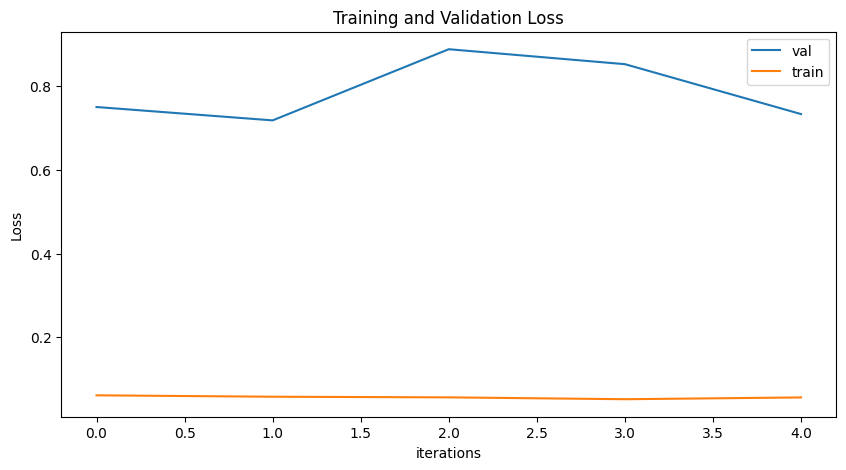

In [68]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

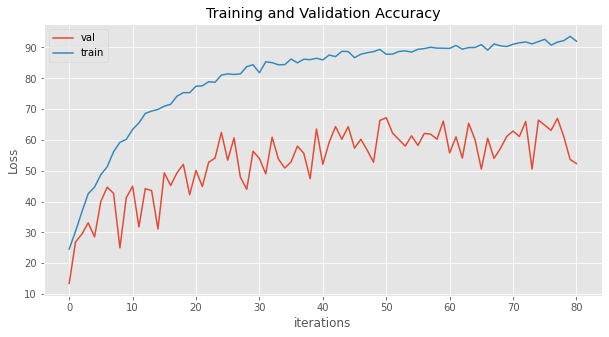

In [15]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(val_accs,label="val")
plt.plot(train_accs,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
correct = 0
total = 0
net.to(device)
confusion_matrix = torch.zeros(6, 6, dtype=torch.int32)
with torch.no_grad():
    for i in tqdm(range(len(test_dataset))):
        real_class = torch.argmax(test_dataset[i][1].to('cuda'))
        x = test_dataset[i][0]
        x = x.unsqueeze(0)
        net_out = net(x.to('cuda'))[0] 
        predicted_class = torch.argmax(net_out)        
        #print (predicted_class.item(),real_class.item())        
        if predicted_class == real_class:
            correct += 1
        total += 1
        for t, p in zip(real_class.view(-1), predicted_class.view(-1)):
                confusion_matrix[t, p] += 1
print("Accuracy: ", round(correct/total, 10))

In [ ]:
confusion_matrix

In [71]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd


# iterate over test data
with torch.no_grad():
    y_pred = []
    y_true = []
    correct = 0
    net.eval()
    net.cpu()
    total = 0
    for inputs, labels in test_data_loader:
           
            
            output = net(inputs) # Feed Network
            
            pred = output.max(1).indices.to(device)
            
            true = labels.max(1).indices.to(device)
            
            output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
            y_pred.extend(output) # Save Prediction
            
            labels = labels.max(1).indices.cpu().numpy()
            y_true.extend(labels) # Save Truth
            
            total += true.size(0)
            correct += torch.sum(pred == true)
# constant for classes
Classes = ('1', '3', '3', '4', '5','6')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)

print("Accuracy: ", (correct/total).item())

Accuracy:  0.8185940980911255


Confusion matrix, without normalization
[[314  20   3   9   0  12]
 [  8 126   5   1   0   1]
 [  0   5  40   1   3   5]
 [  0   0   1  42   0   2]
 [  0   0   2   0  68  10]
 [ 22   1  20  11  18 132]]


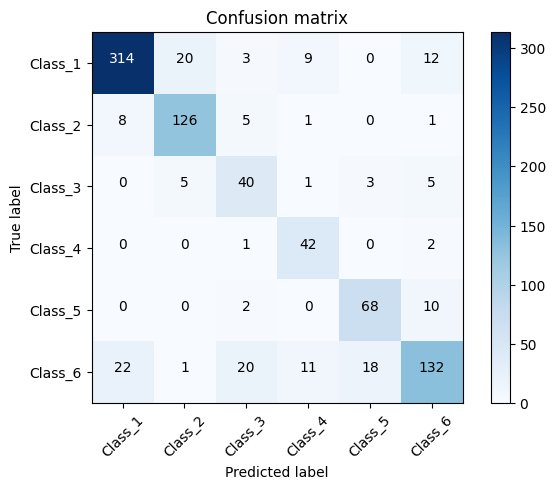

In [72]:
plt.style.use('default')
from plotcm import plot_confusion_matrix
plot_confusion_matrix(cf_matrix, DataSetTrain.data.classes)

In [ ]:
from torchsummary import summary
summary(net, (1, 224, 224))